In [88]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm

from multiprocessing import Pool, cpu_count

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras.callbacks import LambdaCallback, EarlyStopping
import matplotlib.pyplot as plt

In [89]:
df_train = pd.read_csv('inputs/train_v2.csv')
print("Number of records in Training set %d" % len(df_train))
df_train.head(2)

Number of records in Training set 40479


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water


In [90]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
print(labels)

['clear', 'blooming', 'selective_logging', 'habitation', 'cultivation', 'conventional_mine', 'artisinal_mine', 'agriculture', 'haze', 'partly_cloudy', 'cloudy', 'primary', 'bare_ground', 'road', 'water', 'blow_down', 'slash_burn']


In [91]:
input_dir = 'inputs'
subset_size = 1000
img_size = 32
np.random.seed(0)
X = []
Y = []
for f, tags in tqdm(df_train.sample(subset_size).values, miniters=1000):
    f_name = '{}.jpg'.format(f)
#     print(os.path.join(input_dir, 'train-jpg', f_name))
    img = cv2.imread(os.path.join(input_dir, 'train-jpg', f_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    X.append(cv2.resize(img, (img_size, img_size)))
    Y.append(targets)

X = np.array(X, np.float16) / 255.
Y = np.array(Y, np.uint8)

print(X.shape)
print(Y.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 578.32it/s]


(1000, 32, 32, 3)
(1000, 17)


In [92]:
def to_tagging(one_hot_data):
    res = pd.DataFrame(index=range(len(one_hot_data)), columns=['tags'])
    for j in range(len(one_hot_data)):
        tags = []
        for i in range(17):
            if one_hot_data[j][i] == 1:
                tags.append(inv_label_map[i])
        res['tags'][j] = ' '.join(sorted(tags))
    return res

In [93]:
def plot_tags_distribution(df_with_tags):
    labels_destribution = df_with_tags['tags'].apply(lambda x: x.split(' '))
    from collections import Counter, defaultdict
    counts = defaultdict(int)
    for l in labels_destribution:
        for l2 in l:
            counts[l2] += 1

    data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
    layout=dict(height=800, width=800, title='Distribution of training labels')
    fig=dict(data=data, layout=layout)
    py.iplot(data, filename='train-label-dist')

In [94]:
plot_tags_distribution(df_train)

In [95]:
df_train_reduced = to_tagging(Y)
plot_tags_distribution(df_train_reduced)

In [96]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)

In [113]:
# Create small model for reference
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=2, input_shape=(32, 32, 3)))
model.add(Conv2D(64, (2, 2), strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(17, activation='relu'))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                36928     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
__________

In [98]:
def my_callback_func(batch,logs):
    p_valid = model.predict(X_valid, batch_size=4,verbose=2)
    score = fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples')
    fbeta_scores.append(score)

In [114]:
np.random.seed(0)
fbeta_scores = []
my_callback = LambdaCallback(on_epoch_end=lambda batch,logs: my_callback_func(batch,logs))
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=0)
callbacks = [my_callback, early_stop]

batch_size = 4
epochs = 40
history_callback = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
          validation_data=(X_valid, Y_valid), callbacks=callbacks)

p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
p_valid = (np.array(p_valid) > 0.2).astype(int)
score = fbeta_score(Y_valid, p_valid, beta=2, average='samples')
print("F-beta score %f" % score)

Train on 800 samples, validate on 200 samples
Epoch 1/40
1s - loss: 0.3772 - acc: 0.8568 - val_loss: 0.2513 - val_acc: 0.9041
Epoch 2/40
0s - loss: 0.2565 - acc: 0.9023 - val_loss: 0.2546 - val_acc: 0.9050
Epoch 3/40
0s - loss: 0.2524 - acc: 0.9055 - val_loss: 0.2504 - val_acc: 0.9082
Epoch 4/40
0s - loss: 0.2487 - acc: 0.9071 - val_loss: 0.2440 - val_acc: 0.9062
Epoch 5/40
0s - loss: 0.2458 - acc: 0.9071 - val_loss: 0.2368 - val_acc: 0.9076
Epoch 6/40
0s - loss: 0.2398 - acc: 0.9076 - val_loss: 0.2328 - val_acc: 0.9068
Epoch 7/40
0s - loss: 0.2400 - acc: 0.9059 - val_loss: 0.2407 - val_acc: 0.9038
Epoch 8/40
0s - loss: 0.2362 - acc: 0.9076 - val_loss: 0.2319 - val_acc: 0.9074
Epoch 9/40
0s - loss: 0.2359 - acc: 0.9081 - val_loss: 0.2281 - val_acc: 0.9115
Epoch 10/40
0s - loss: 0.2341 - acc: 0.9086 - val_loss: 0.2291 - val_acc: 0.9079
Epoch 11/40
0s - loss: 0.2332 - acc: 0.9107 - val_loss: 0.2265 - val_acc: 0.9076
Epoch 12/40
0s - loss: 0.2325 - acc: 0.9086 - val_loss: 0.2221 - val_acc

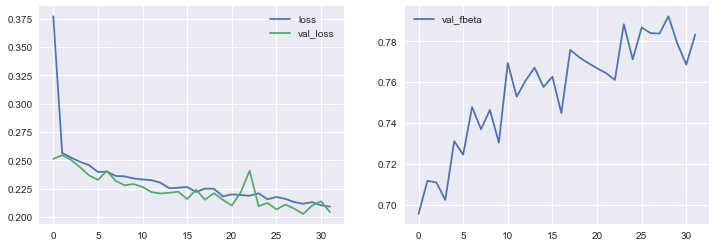

In [116]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(fbeta_scores)
plt.legend(labels=['val_fbeta'])
plt.show()

In [117]:
plot_tags_distribution(to_tagging(Y_train))

In [118]:
plot_tags_distribution(to_tagging(Y_valid))

In [121]:
y_predicted = model.predict(X_valid, batch_size=4)

In [152]:
scores = np.zeros(17)
rat = np.zeros(17)
step = 0.05
n = int(1/step)
for j in range(17):
    r = step
    for i in range(n):
        score = fbeta_score(Y_valid[:,j], (y_predicted[:,j] > r).astype(int), beta=2)
        if score > scores[j]:
            scores[j] = score
            rat[j] = r
        r+=step

J:\Anaconda3_4.3.0_Python3.6\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



In [160]:
rat[rat == 0] = step
rat

array([ 0.5 ,  0.05,  0.05,  0.15,  0.05,  0.05,  0.05,  0.15,  0.25,
        0.1 ,  0.05,  0.5 ,  0.05,  0.1 ,  0.1 ,  0.05,  0.05])

In [154]:
scores

array([ 0.94722598,  0.        ,  0.        ,  0.54166667,  0.4020979 ,
        0.        ,  0.        ,  0.78680203,  0.78431373,  0.61023622,
        0.70422535,  0.99252935,  0.        ,  0.65602837,  0.52631579,
        0.        ,  0.        ])

In [166]:
avg = 'samples'
print(fbeta_score(Y_valid, (y_predicted>0.2).astype(int), beta=2, average=avg))
print(fbeta_score(Y_valid, (y_predicted>rat).astype(int), beta=2, average=avg))

0.783328151254
0.772245911068


In [119]:
for i in range(17):
    print("%s: %f" % (inv_label_map[i], fbeta_score(Y_valid[:,i], p_valid[:,i], beta=2)))

clear: 0.939153


J:\Anaconda3_4.3.0_Python3.6\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



blooming: 0.000000
selective_logging: 0.000000
habitation: 0.370370
cultivation: 0.051546
conventional_mine: 0.000000
artisinal_mine: 0.000000
agriculture: 0.745257
haze: 0.689655
partly_cloudy: 0.563380
cloudy: 0.701754
primary: 0.985169
bare_ground: 0.000000
road: 0.640000
water: 0.292553
blow_down: 0.000000
slash_burn: 0.000000


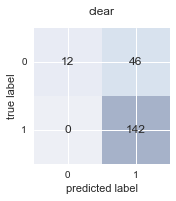

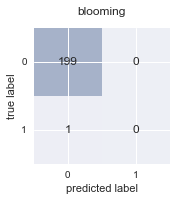

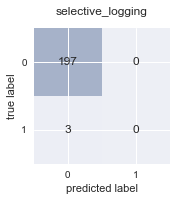

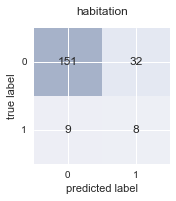

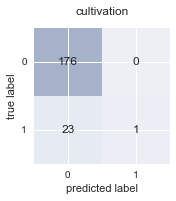

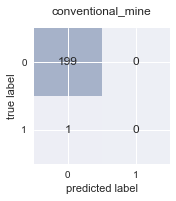

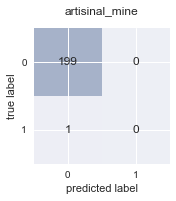

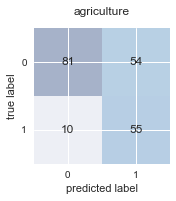

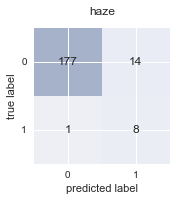

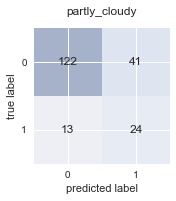

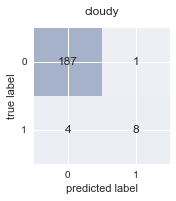

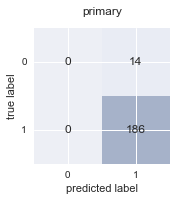

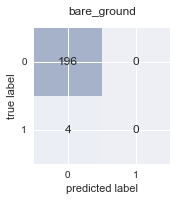

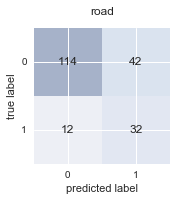

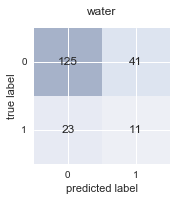

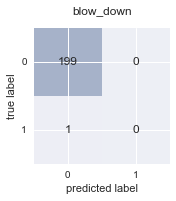

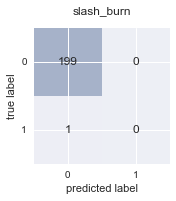

In [120]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
for i in range(17):
    cm = confusion_matrix(y_target=Y_valid[:,i], 
                      y_predicted=p_valid[:,i], binary=False)
    _, ax = plot_confusion_matrix(conf_mat=cm)
    ax.set_title(inv_label_map[i])
plt.show()